In [1]:
from func import DataProcessor,TipFinder,VertexPos
import seaborn as sns
from plotly.offline import iplot,plot
import numpy as np
import pylab as plt
import pandas as pd
from scipy import stats
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)


In [2]:
dp = DataProcessor('../../data/SQL/10C/85_8.db','../../data/SQL/10C/ProtoMap.db')

initialization will take some time
6.51205182076
   PadNum        PadName     PadX      PadY  BinNum
0       0  sector_center  0.00000  0.000000     257
1       1      sector1_0  1.30108  0.947523       1
2       2      sector2_0  2.18496  1.831410       2
3       3      sector1_1  2.71529  2.361740       3
4       4      sector2_1  3.59917  3.245620       4
loading finished
begin processing
0.973426103592
2.18962883949
processing finished


In [3]:
def AveDist(x,y,k,b):
    return np.sum(np.abs(k*x+b-y)/(k*k+1))/x.shape[0]

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value*r_value

def DoIt(fits,pic,y0):
    pic = np.copy(pic)    
    if sum([f[0]>60 for f in fits]) == 0: raise Exception('This is probably an unreacted beam')
    
    max_idx = max(zip(range(4),fits),key=lambda x:x[1][0])[0]
    opp_idx = (max_idx+2)%4
    print max_idx, opp_idx

    k1,b1 = fits[max_idx][1:3]
    if fits[opp_idx][0]>50:
        k2,b2 = fits[opp_idx][1:3]
        return (b2-b1)/(k1-k2), (k2*b1-k1*b2)/(k2-k1)
    else:
        x0 = (y0-b1)/k1
        pic[:,:int(x0)+5]=0
        yy,xx = np.where(pic)
        
        k2,b2 = np.polyfit(xx,yy,1)
        if r2(xx,yy)>0.5: 
            return (b2-b1)/(k1-k2), (k2*b1-k1*b2)/(k2-k1)
        else:
            return x0,y0

def Process(pic,images):
    pic_ = np.copy(pic)

    score,y0,y1 = VertexPos(pic_)
    points = TipFinder(pic_)
    xv,yv = points[points[:,0].argsort()][-1]
    
    #### get fit from each of the quadrant ###
    width = 20
    thre = 80
    fits = []
    for idx,image in enumerate(images):
        image = np.copy(image)
        image[int(yv)-width:int(yv)+width,:] = 0
        if np.sum(image>10) > 60:
            ys,xs = np.where(image)

            try:
                k,b = np.polyfit(xs,ys,1)
                if r2(xs,ys)>0.8:
                    fits.append((np.sum(image>10),k,b,r2(xs,ys)))
                else:
                    fits.append((0,0,0,100))
            except:
                fits.append((0,0,0,100))

        else:
            fits.append((0,0,0,100))
            
    ### process the fits according to each of the scenario
    return DoIt(fits,pic,yv)



0 2


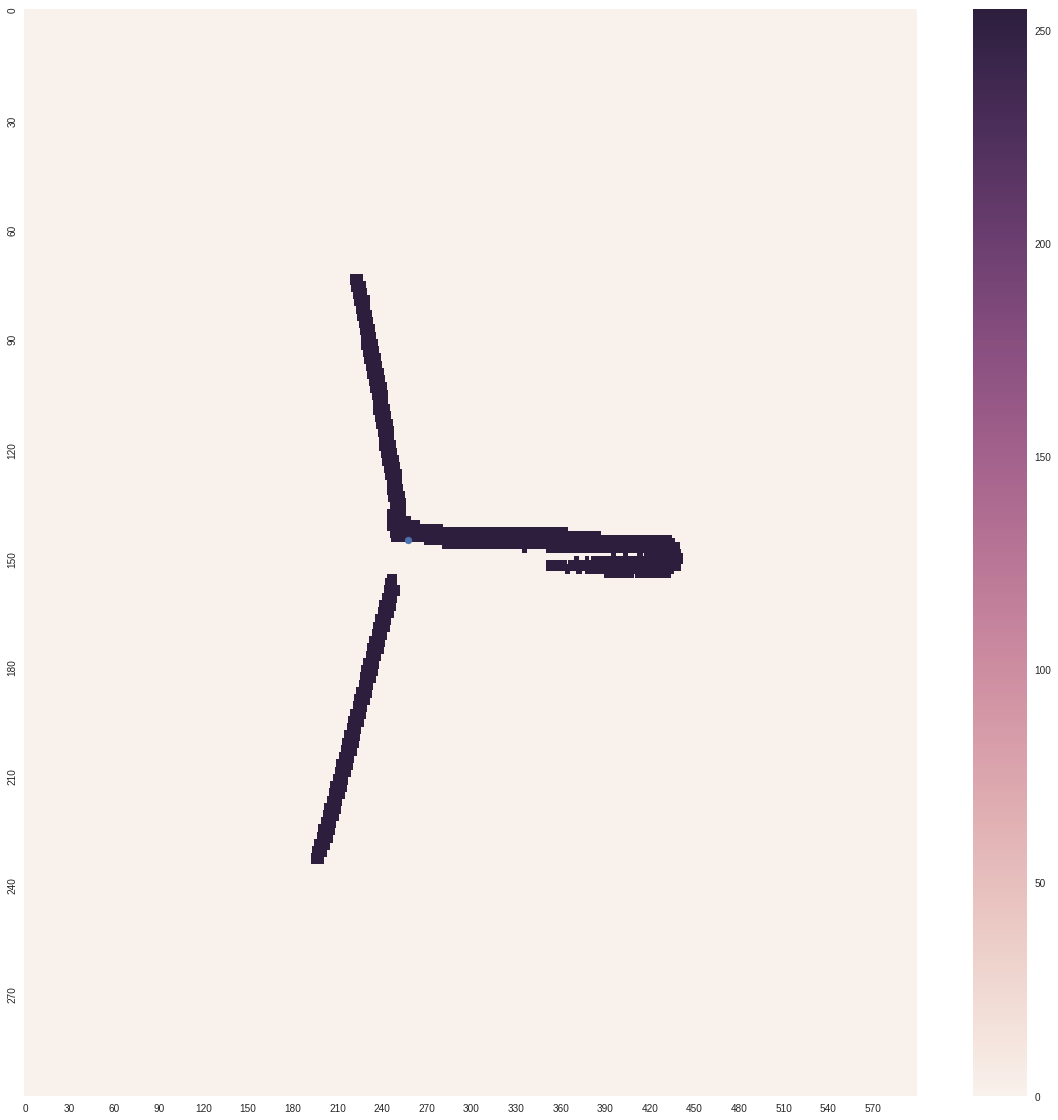

In [4]:
pic, images = dp.Process1(9)
sns.heatmap(pic[::-1], xticklabels=30, yticklabels=30)
xc,yc = Process(pic, images)
plt.scatter([xc],[yc])